<a href="https://colab.research.google.com/github/MartinPSE/StandAloneDL/blob/master/CIFAR_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print(torch.__version__)

1.10.0+cu111


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import argparse
import numpy as np

## Data Preparation

In [85]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val': valset, 'test' : testset}

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


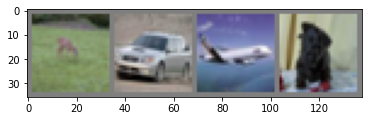

 deer		  car		plane		  dog
<class 'torch.Tensor'> torch.Size([4, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([4]) tensor([4, 1, 0, 5])


In [4]:
import matplotlib.pyplot as plt


def imshow(img):
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

# get some random training images

dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print('\t\t'.join ('%5s' % classes[labels[j]]  for j in range(4)))

# type 과 shape
print(type(images), images.shape) # batch_size, 차원(RGB) , 가로, 세로 
print(type(labels), labels.shape, labels)

## Model Architecture

In [ ]:
# 3072 차원 짜리 Image
# 3(channels) 32 * 32 ( total 3072 dim )


In [79]:
# Build MLP Architecture

class MLP(nn.Module):
  def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, dropout, use_bn, use_xavier):
    super(MLP, self).__init__()
    self.in_dim = in_dim # forward에서 값을 사용할 수도 있다.
    self.out_dim = out_dim
    self.hid_dim = hid_dim
    self.n_layer = n_layer
    self.act = act
    self.dropout = dropout
    self.use_bn = use_bn
    self.use_xavier = use_xavier

    # 층 설계
    self.fc =  nn.Linear(self.in_dim, self.hid_dim)



    self.linears = nn.ModuleList()
    self.bns = nn.ModuleList()
    for i in range(self.n_layer-1):
      self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
      if self.use_bn:
        self.bns.append(nn.BatchNorm1d(self.hid_dim))

    self.fc2 = nn.Linear(self.hid_dim, self.out_dim)

    if self.act == 'relu':
      self.act = nn.ReLU()
    elif self.act =='tanh':
      self.act = nn.Tanh()
    elif self.act =='sigmoid':
      self.act = nn.Sigmoid()
    else:
      raise ValueError('No valid activation function selected')


    # Create Regularization Layer 
    self.dropout = nn.Dropout(self.dropout)
    if self.use_xavier:
      self.xavier_init()

  def forward(self, x):
    x = self.act(self.fc(x))
    for i in range(len(self.linears)):
      x = self.act(self.linears[i](x))
      x = self.bns[i](x)
      x=  self.dropout(x)
      
    x = self.fc2(x) # 마지막 layer는 activate function 통과 X 
    return x
  
  # Xavier Function 
  def xavier_init(self):
    for linear in self.linears:
      nn.init.xavier_normal_(linear.weight) # linear의 W Parameter  // normal 과 uniform 2가지 
      linear.bias.data.fill_(0.01) # linear 의 b를 초기화 


net = MLP(3072, 10, 100, 4, 'relu', 0.1, True, True) # Testing Model Construction

## Define Experiment

In [92]:
def train(net, partition, optimizer, criterion, args):
  trainloader = torch.utils.data.DataLoader(partition['train'], 
                                            batch_size = args.train_batch_size ,
                                            shuffle = True,
                                            num_workers = 2)
  train_loss_list = []

  net.train()
  optimizer.zero_grad()

  train_loss = 0.0 
  total = 0.0
  correct = 0.0
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 3072)
    # GPU에 넣자
    inputs = inputs.cuda()
    labels = labels.cuda()

    outputs = net(inputs)

    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    
  train_loss = train_loss / len(trainloader)
  train_acc = 100 * correct / total

  train_loss_list.append(train_loss)

  return net, train_loss, train_acc, train_loss_list



In [100]:
def validate(net, partition, criterion, args):
  valloader = torch.utils.data.DataLoader(partition['val'], 
                                          batch_size = args.test_batch_size,
                                          shuffle = True,
                                          num_workers = 2)
  
  net.eval()

  val_acc_list = []
  val_loss_list = []
  correct = 0
  total = 0
  val_loss =0
  with torch.no_grad():
    for data in valloader:
      images, labels = data
      images = images.view(-1, 3072)
      images = images.cuda()
      labels = labels.cuda()

      outputs = net(images)

      loss = criterion(outputs, labels)
      val_loss = loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(valloader)
    val_acc = 100 * correct / total
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
  return val_loss, val_acc, val_loss_list, val_acc_list


In [101]:
def test(net, partition, args):
  testloader = torch.utils.data.DataLoader(partition['test'], 
                                           batch_size = args.test_batch_size,
                                           shuffle= False,
                                           num_workers = 2)
  
  net.eval()

  test_acc_list = []
  correct = 0
  total = 0
  with torch.no_grad():
    for data in testloader:
      images, labels = data
      images = images.view(-1, 3072)
      images = images.cuda()
      labels = labels.cuda()

      outputs = net(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
    test_acc = 100 * correct / total
    test_acc_list.append(test_acc)
    
  return test_acc, test_acc_list
  

      


In [110]:
import time

def experiment(partition, args):
  net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act, args.dropout, args.use_bn, args.use_xavier)
  net.cuda()

  criterion = nn.CrossEntropyLoss()
  if args.optim =='SGD':
    optimizer = optim.SGD(net.parameters(), lr = args.lr, weight_decay=args.l2)
  elif args.optim =='RMSprop':
    optimizer = optim.RMSprop(net.parameters(), lr = args.lr, weight_decay=args.l2)
  elif args.optim =='Adam':
    optimizer = optim.Adam(net.parameters(), lr = args.lr, weight_decay=args.l2)
  else:
    raise ValueError('In-valid optimizer choice')

  for epoch in range(args.epoch):
    ts = time.time()
    net, train_loss, train_acc, train_loss_list = train(net, partition, optimizer, criterion, args)
    val_loss, val_acc, val_loss_list, val_acc_list = validate(net, partition, criterion, args)
    te = time.time()

    print(f'Epoch : {epoch}, Train Acc : {train_acc:2.2f} , Valid Acc : {val_acc:2.2f}, Took : {(te-ts):2.2f} sec')
    
  test_acc = test(net, partition,args)
  return train_loss, val_loss, train_acc, val_acc, test_acc, train_loss_list, val_acc_list




### MLP HyperParameter Tunning
---

In [ ]:
import argparse

# Random Seed Initialzation 
seed = 123
np.random.seed(seed) #numpy seed 고정
torch.manual_seed(seed) # torch seed 고정 
parser = argparse.ArgumentParser()
args = parser.parse_args("")

# Model Capacit y
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 200
args.act = 'relu'

# Regularization 
args.dropout = 0.2
args.use_bn = True
args.l2= 0.00001
args.use_xavier = True

# Optimizer & training 
args.optim = 'RMSprop' # SGD Adam
args.lr = 0.0015
args.epoch = int(input(' EPOCH 를 입력해주세요 !! '))

args.train_batch_size = 256
args.test_batch_size = 1024

# Experiment variable
name_var1 = 'n_layer'
name_var2 = 'hid_dim'
list_var1=[3,3,4]
list_var2=[500,300,700]

for var1 in list_var1:
  for var2 in list_var2:
    setattr(args, name_var1, var1)
    setattr(args, name_var2, var2)
    print(args)
    result = experiment(partition, args)




 EPOCH 를 입력해주세요 !! 10
Namespace(act='relu', dropout=0.2, epoch=10, hid_dim=500, in_dim=3072, l2=1e-05, lr=0.0015, n_layer=3, optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=256, use_bn=True, use_xavier=True)
Epoch : 0, Train Acc : 22.64 , Valid Acc : 26.96, Took : 11.33 sec
Epoch : 1, Train Acc : 27.75 , Valid Acc : 30.67, Took : 11.30 sec
Epoch : 2, Train Acc : 31.97 , Valid Acc : 34.82, Took : 11.28 sec
Epoch : 3, Train Acc : 35.78 , Valid Acc : 37.16, Took : 11.31 sec
Epoch : 4, Train Acc : 37.95 , Valid Acc : 39.17, Took : 11.27 sec
Epoch : 5, Train Acc : 40.10 , Valid Acc : 40.46, Took : 11.29 sec
Epoch : 6, Train Acc : 42.79 , Valid Acc : 41.84, Took : 11.34 sec
Epoch : 7, Train Acc : 44.91 , Valid Acc : 44.92, Took : 11.26 sec
Epoch : 8, Train Acc : 47.94 , Valid Acc : 46.48, Took : 11.25 sec
Epoch : 9, Train Acc : 50.02 , Valid Acc : 47.42, Took : 11.36 sec
Namespace(act='relu', dropout=0.2, epoch=10, hid_dim=300, in_dim=3072, l2=1e-05, lr=0.0015, n_layer=3,

## Using CNN
---
  CNN도 Custom 해서 만들어보기

### HyperParameter Tunning
---

In [53]:
class Cifar10CnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [61]:
def experiment2(args):
  net = Cifar10CnnModel()
  net.cuda()
  print(net)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr = args.lr, momentum = args.mm)
  epoch_list = []
  train_loss_list = []
  val_loss_list = []
  val_acc_list = [] 

  for epoch in range(args.epoch):
    epoch_list.append(epoch)


    running_loss = 0.0
    train_loss = 0.0 
    for i, data in enumerate(trainloader, 0):
      inputs, labels = data

      # GPU에 넣자
      inputs = inputs.cuda()
      labels = labels.cuda()

      optimizer.zero_grad()

      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      train_loss += loss.item()
      if i % 2000 == 1999: # print every 2000 mini-batches
        print(f'[{epoch + 1}, {i+1}] loss : {running_loss/2000:1.3f}')
        running_loss = 0
    train_loss_list.append(train_loss)
    print('train_loss_의 길이:', len(train_loss_list))
      
    # === Validation === 
    correct = 0
    total = 0
    val_loss = 0

    with torch.no_grad():
      for data in valloader:
        images, labels = data

        images = images.cuda()
        labels = labels.cuda()

        outputs = net(images)
        
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
      val_loss = val_loss / len(valloader)
      val_loss_list.append(val_loss)
      print('val_loss의 길이 :',len(val_loss_list))

      val_acc = 100 * correct / total
      val_acc_list.append(val_acc)
      print('val_acc의 길이 : ',  len(val_acc_list))
      print(args)
      print(f'Epoch : {epoch}, Train Loss : {train_loss}, Validation Loss : {val_loss} , Val Accuracy : {val_acc}')
      
  # === Evaluation ====
  correct = 0
  total = 0
  with torch.no_grad():
    for data in testloader:
      images, labels = data

      images = images.cuda()
      labels = labels.cuda()
      outputs = net(images)

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    test_acc = 100 * correct / total

    fig = plt.figure(figsize=(15,5))

    # ====== Loss Fluctuation ====== #
  ax1 = fig.add_subplot(1, 2, 1)
  ax1.plot(epoch_list, train_loss_list, label='train_loss')
  ax1.plot(epoch_list, val_loss_list, '--', label='val_loss')
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('loss')
  ax1.grid()
  ax1.legend()
  ax1.set_title('epoch vs loss')

  # ====== Metric Fluctuation ====== #
  ax2 = fig.add_subplot(1, 2, 2)
  ax2.plot(epoch_list, val_acc_list, marker='x', label='Accuracy metric')
  ax2.set_xlabel('epoch')
  ax2.set_ylabel('Acc')
  ax2.grid()
  ax2.legend()
  ax2.set_title('epoch vs Accuracy')

  plt.show()

    
  return train_loss, val_loss, train_loss, val_acc 
    





In [65]:
import argparse

seed = 123
np.random.seed(seed) #numpy seed 고정
torch.manual_seed(seed) # torch seed 고정 

parser = argparse.ArgumentParser()
args = parser.parse_args("")


args.n_layer = 5
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 200
args.act = 'relu'

args.lr = 0.001
args.mm = 0.9
args.epoch = int(input(' EPOCH 를 입력해주세요 !! '))



list_var1 = [0.001, 0.0005, 0.0001, 0.00005]
list_var2 = [0.90, 0.95, 0.99]
list_var3 = [3, 5, 7, 10]


for var1 in list_var1:
  for var2 in list_var2:
    for var3 in list_var3:
      args.lr = var1
      args.mm = var2
      args.n_layer = var3


result = experiment2(args)
    





 EPOCH 를 입력해주세요 !! 10
MLP(
  (fc): Linear(in_features=3072, out_features=200, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=200, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=200, bias=True)
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): Linear(in_features=200, out_features=200, bias=True)
    (6): Linear(in_features=200, out_features=200, bias=True)
    (7): Linear(in_features=200, out_features=200, bias=True)
    (8): Linear(in_features=200, out_features=200, bias=True)
  )
  (fc2): Linear(in_features=200, out_features=10, bias=True)
  (act): ReLU()
)


RuntimeError: ignored

In [ ]:
1